# L2 regularization for normalizing flow training

This notebook showcases the effect of using L2 regularization when training normalizing flows. We consider a heavy-tailed 100-dimensional target distribution. We only use 50 training points as regularization is typically adopted in small-data scenarios. The full objective that includes L2 regularization with coefficient $\lambda > 0$ is defined as:
$$
\min_\theta -\frac{1}{n}\sum_{i=1}^n \log q_\theta(x_i) + \lambda \cdot \frac{1}{M} \sum_{j=1}^M p_j^2, 
$$
where the second term sums over all $M$ parameters of conditioner neural networks in the autoregressive architecture and the first term is the average negative log density under the flow.

In [1]:
from normalizing_flows import Flow
from normalizing_flows.architectures import RealNVP, MAF, CouplingRQNSF
import torch
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)

n_dim = 100
x_train = torch.log(torch.randn(size=(50, n_dim)) ** 2)
x_val = torch.log(torch.randn(size=(50, n_dim)) ** 2)
x_test = torch.log(torch.randn(size=(10000, n_dim)) ** 2)

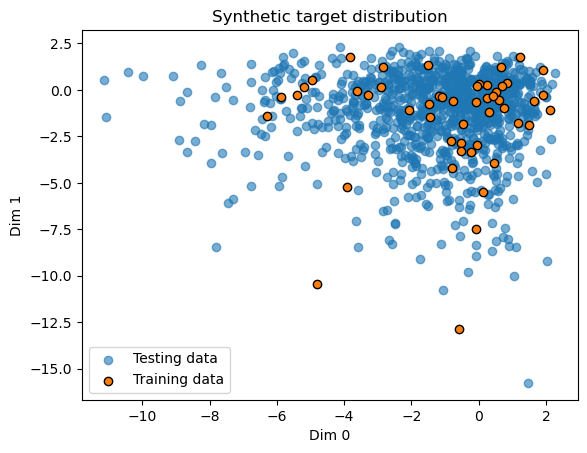

In [3]:
plt.figure()
plt.scatter(x_test[:1000, 0], x_test[:1000, 1], label="Testing data", alpha=0.6)
plt.scatter(x_train[:, 0], x_train[:, 1], label="Training data", ec="k")
plt.legend()
plt.xlabel("Dim 0")
plt.ylabel("Dim 1")
plt.title("Synthetic target distribution")
plt.show()

In [4]:
torch.manual_seed(0)
print('Test losses for various architectures and training configurations')
print('-' * 70)

for architecture_class in [RealNVP, MAF, CouplingRQNSF]:
    print(f'Architecture: {architecture_class.__name__}')

    basic_m = Flow(architecture_class(event_shape=(n_dim,)))
    basic_m.fit(x_train, show_progress=False, n_epochs=2000)
    print(f'> Basic: {-float(torch.mean(basic_m.log_prob(x_test))):.3f}')

    reg_m = Flow(architecture_class(event_shape=(n_dim,)))
    reg_m.fit(x_train, l2_lambda=0.01, show_progress=False, n_epochs=2000)
    print(f'> L2 regularization: {-float(torch.mean(reg_m.log_prob(x_test))):.3f}')
    
    val_m = Flow(architecture_class(event_shape=(n_dim,)))
    val_m.fit(x_train, show_progress=False, n_epochs=2000, x_val=x_val, early_stopping=True)
    print(f'> Early stopping: {-float(torch.mean(val_m.log_prob(x_test))):.3f}')
    
    reg_val_m = Flow(architecture_class(event_shape=(n_dim,)))
    reg_val_m.fit(x_train, show_progress=False, n_epochs=2000, x_val=x_val, early_stopping=True, l2_lambda=0.01)
    print(f'> Regularization + early stopping: {-float(torch.mean(reg_val_m.log_prob(x_test))):.3f}')

    print()

Test losses for various architectures and training configurations
----------------------------------------------------------------------
Architecture: RealNVP
> Basic: 1741826.500
> L2 regularization: 9801.797
> Early stopping: 232.762
> Regularization + early stopping: 236.122

Architecture: MAF
> Basic: 22940.367
> L2 regularization: 949.414
> Early stopping: 235.935
> Regularization + early stopping: 241.435

Architecture: CouplingRQNSF
> Basic: 233.587
> L2 regularization: 366.490
> Early stopping: 229.336
> Regularization + early stopping: 229.629


These results show that L2 regularization itself does not significantly affect test loss. Most of the work is done by using a validation set with early stopping.